In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
from time import time

import matplotlib.pyplot as plt

sns.set()

## 1 Exploratory analysis

Source of the dataset: https://www.kaggle.com/datasnaek/mbti-type

MBTI (Myers-Briggs Type Indicator) is a system used for determining personality types. It's a four-letter code, where eeach letter represents one of the four axis: 
- Source of energy: Extroversion(E) - Introversion(I)
- Way of gathering information: Sensing(S) - Intuitive(N)
- Decision making: Thinking(T) - Feeling(F)
- Relation to external world: Judgment(J) - Perception(P)

Dataset contains over 8 000 rows of data and each row has a label - the given personality type, and aggregate posts of a person.

In [3]:
df = pd.read_csv('./mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
df.type = df.type.astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   type    8675 non-null   category
 1   posts   8675 non-null   object  
dtypes: category(1), object(1)
memory usage: 77.1+ KB


## Analysis on separated posts

In [5]:
df_post = df.copy()
df_post.posts = df_post.posts.str.split('\|\|\|')
df_post["post_count"] = df_post.posts\
    .apply(lambda x: len(x))
df_post["words_count"] = df_post.posts\
    .apply(lambda x: sum(map(lambda it: len(it.split()), x)))

In [6]:
df_post_single = df_post.drop(columns=['post_count', 'words_count']).explode('posts').reset_index(drop=True)
df_post_single.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,INFJ,enfp and intj moments https://www.youtube.com...
3,INFJ,What has been the most life-changing experienc...
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...


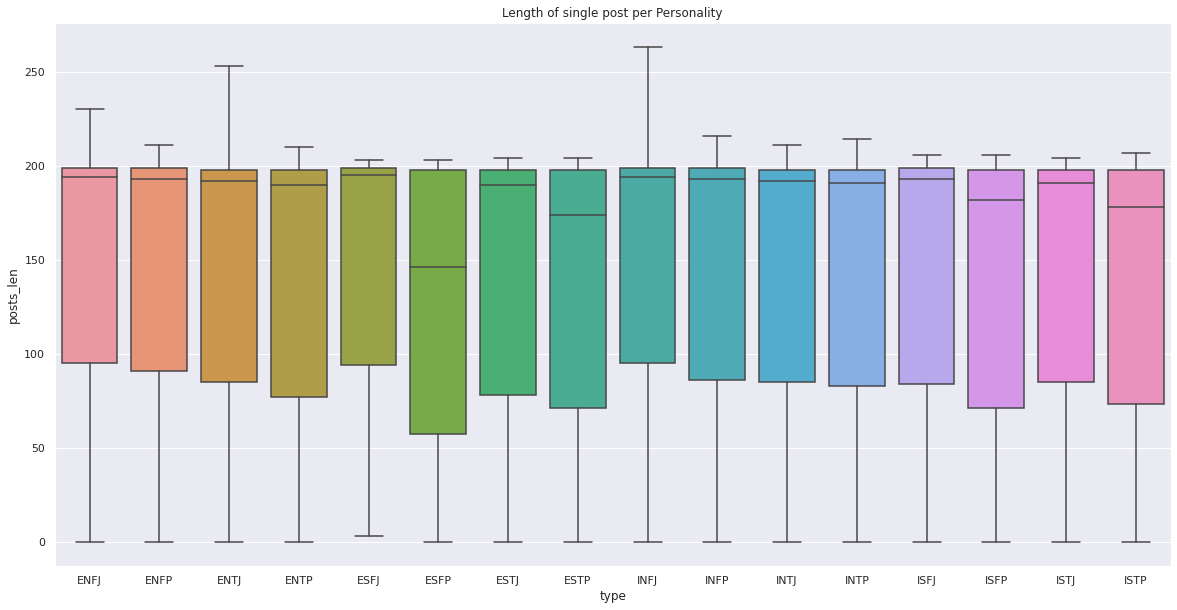

In [7]:
post_lengths = df_post_single.copy()
post_lengths["posts_len"] = df_post_single.posts.str.len()

fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(20,10))
sns.boxplot(x="type",y="posts_len",data=post_lengths)
plt.title('Length of single post per Personality')
plt.show()

In [8]:
print("Empty posts:", len(post_lengths[post_lengths.posts_len == 0]))
print("Short posts:", len(post_lengths[(post_lengths.posts_len > 0) & (post_lengths.posts_len < 10)]))

Empty posts: 1088
Short posts: 7010


In [9]:
print("Post count mean:", df_post.post_count.mean())
print("Post count deviation:", df_post.post_count.std())
print("Post count quantile (5% - 95%):", df_post.post_count.quantile(q=0.05), "-", df_post.post_count.quantile(q=0.95))

Post count mean: 48.74293948126801
Post count deviation: 5.475907310807388
Post count quantile (5% - 95%): 39.0 - 50.0


### Comment
The average length of a single post is about 200 characters. We can see, that there are some empty or very short posts in our dataset. Therefore it would be better to use aggregated posts as we merge these empty posts with some meaningful.

We don't lost too much information, because the standard deviation of post count is quite small and 90% of data range between 39-50 posts

## Analysis on aggreagted posts

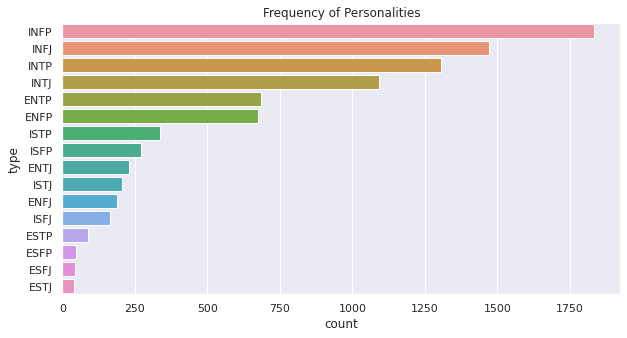

In [10]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(10,5))
sns.countplot(data=df, y='type', order=df['type'].value_counts().index, ax=ax1)
plt.title('Frequency of Personalities')
plt.show()

### Comment
We can see that the most represented personality type is INFP, while the least represented are the ES types.

In [13]:
spectrums = pd.Series(index=pd.Index(['I', 'N', 'F', 'P', 'E', 'S', 'T', 'J'], name="spectrum"), data=np.zeros(8, dtype=int))

In [14]:
def count_specs(personality):
    for spec in list(personality):
        spectrums.loc[spec] += 1

In [15]:
for personality in df['type'].to_numpy(dtype='str'):
    count_specs(personality)

Text(0.5, 1, 'Spectrums of Personalities')

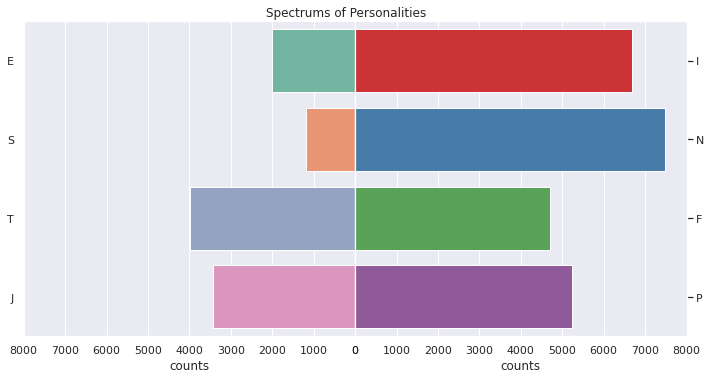

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(10,5))
fig.tight_layout()
first_plt = sns.barplot(data=spectrums[:'P'].reset_index(name="counts"), palette='Set1', y='spectrum', x='counts', ax=ax2)
ax2.axis(xmin=0,xmax=8000)
first_plt.yaxis.tick_right()
first_plt.set(ylabel=None)


second_plt = sns.barplot(data=spectrums['E':].reset_index(name="counts"), palette='Set2', y='spectrum', x='counts', ax=ax1)
ax1.axis(xmin=0,xmax=8000)
second_plt.set(ylabel=None)
second_plt.invert_xaxis()

fig.subplots_adjust(wspace=0)
fig.suptitle('Spectrums of Personalities', y=1)

### Comment

From the Spectrum of Personalities plot, where each row represents one of the axis used for determining the personality type, we can see that axis EI and SN are very imbalanced, which causes big differences in the representation of personality types. We can see that from the fact that the IN personality types are overrepresented, while the ES types are underrepresented.

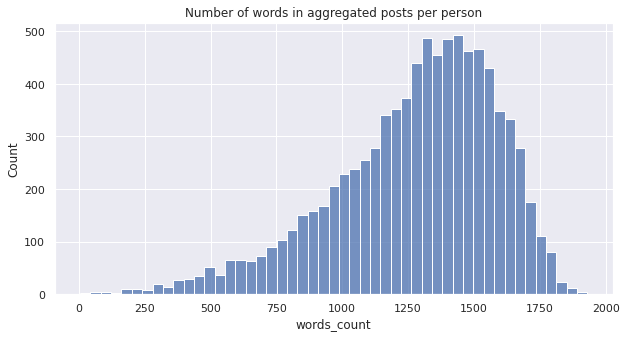

In [6]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(10,5))
sns.histplot(data=df_post, x="words_count", ax=ax1)
plt.title('Number of words in aggregated posts per person')
plt.show()

### Comment ###

We can see that the lengths of agregated posts range from very short (0-100 words) to very long (around 1900 words), but they are mostly around 1250-1600 words per person.

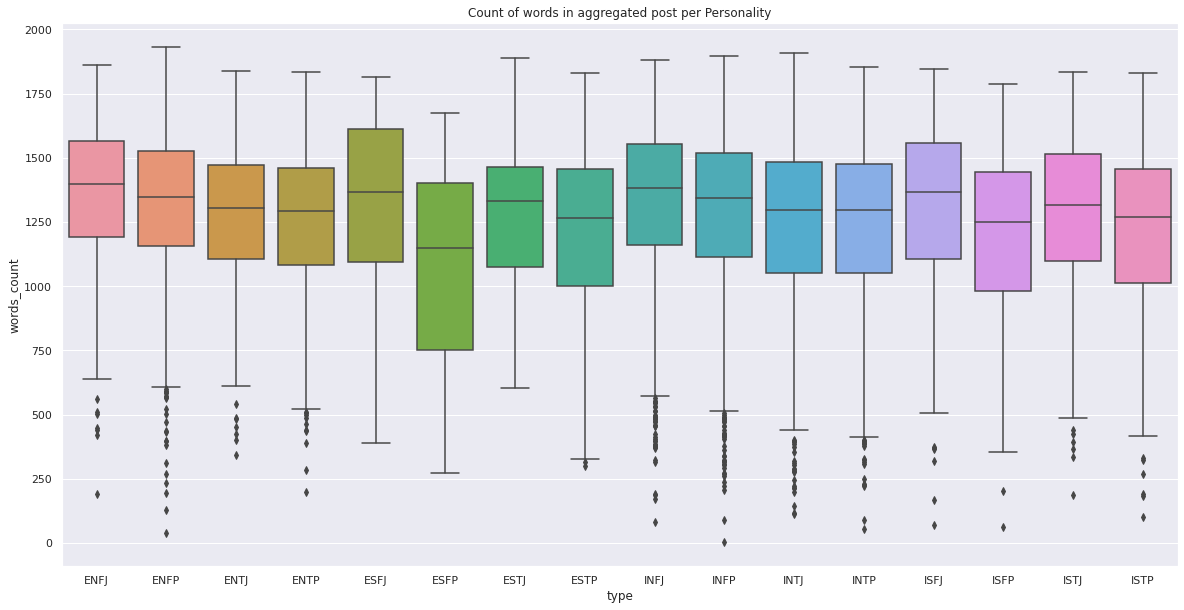

In [11]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(20,10))
sns.boxplot(x="type",y="words_count",data=df_post)
plt.title('Count of words in aggregated post per Personality')
plt.show()

In [7]:
df_post[df_post.words_count<50]

,type,posts,post_count,words_count
774,ENFP,['Says you. He's not cute - he's pure evil in...,1,38
3559,INFP,"['9, 8 and 6, http://www.youtube.com/watch?v=D...",2,5


### Comment
Choice of aggregated posts seems successful, because we get rid of non meaningful data, even short posts contain at least some non link words.

## 2 Preprocessing

For preprocessing we use NLTK which standard library used for NLP related tasks. With it we define lemmatizer that helps us to convert words to their root. This is acheived by determining the correct tag for a word (Whether it is adjective, noun and so on) and then applying WordNetLemmatizer.lemmatize function. From NLTK we also utilize stopwords to filter out words that do not provide any additional meaning to the sentences.

When running preprocessing we first lowercase all posts, then run regexes to remove links and non-alphabetic characters and at the end run lemmatizer and filter stopwords through CountVectorizer function.

In [3]:
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

from importlib_metadata import version
print('nltk ', version('nltk'))

nltk  3.7


Need to download nltk related utilities when running first time

In [18]:
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('omw-1.4')

Removing links and non-alphabetic characters (except " ' ")

In [4]:
def sub_re(doc):
    no_links = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", "", doc)
    return re.sub("[^A-Za-z]+", " ", no_links)

sub_re_np = np.vectorize(sub_re)

In [5]:
# source https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

### Lemmatization

Lematizer for vectorizer so we convert words to their root form for example: running -> run

In [6]:
# src sklearn documentation
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`'] # this is redundant since those characters are removed in preprocessing
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
# also ignoring words of length greater length than 2
        return [self.wnl.lemmatize(t, get_wordnet_pos(t)) for t in word_tokenize(doc) if (t not in self.ignore_tokens and len(t) > 2)]

### Stopwords

In [7]:
stop_words = list(set(stopwords.words('english')))

# Lematazing Stopwords for Vectorizers
tokenizer=LemmaTokenizer()
token_stop = list(map(lambda x: re.sub("'", "", x), list(set((tokenizer(' '.join(stop_words))))))) # list and set to remove duplicates

### Vectorizers

In [8]:
max_feat = 2000

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer(analyzer= 'word', stop_words=token_stop, tokenizer=tokenizer, max_features=max_feat)

### Split Dataset

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['posts'].to_numpy(dtype='str'), 
    df['type'].to_numpy(dtype='str'), 
    test_size=0.20, random_state=42)

print('Train set size', X_train.size)
print('Test set size', X_test.size)

Train set size 6940
Test set size 1735


### Run Preprocessing

In [11]:
run_preprocessing = False

In [27]:
# first lowercase and clean data and then run tfidf 
if run_preprocessing:
    t = time()
    X_train_count = count_vec.fit_transform(sub_re_np(np.char.lower(X_train)))
    print(f'Time to preprocess: {round((time() - t) / 60, 2)} mins')

In [12]:
# Get TFIDF matrix
from sklearn.feature_extraction.text import TfidfTransformer
if run_preprocessing:
    tfidf_transform = TfidfTransformer()
    X_train_tfidf = tfidf_transform.fit_transform(X_train_count)
    print('Size of the vocabulary:', len(count_vec.vocabulary_))

Save count matrix and its feature names since computation takes long

In [13]:
if run_preprocessing:
    np.save(f'./X_train_count_{max_feat}.npy', X_train_count.toarray())
    np.save(f'./X_train_tfidf_{max_feat}.npy', X_train_tfidf.toarray())
    np.save(f'./count_{max_feat}_feature_names.npy', np.array(count_vec.get_feature_names()))

If you want preporcessed posts in string format run this

In [30]:
# count_analyzer_np = np.vectorize(count_vec.build_analyzer(), otypes='O')
# post_preprocessed = count_analyzer_np(posts_clean)

Load saved matrices

In [14]:
if not run_preprocessing:
    X_train_count = np.load(f'./X_train_count_{max_feat}.npy')
    X_train_tfidf = np.load(f'./X_train_tfidf_{max_feat}.npy')
    feature_names = np.load(f'./count_{max_feat}_feature_names.npy')
    print('Loaded X_train_count', X_train_count.shape)
    print('Loaded X_train_tfidf', X_train_tfidf.shape)
    print(len(feature_names))

Loaded X_train_count (6940, 2000)
Loaded X_train_tfidf (6940, 2000)
2000


Filter out aggregate posts with zero words after preprocessing

In [15]:
zero_filter = np.sum(X_train_count, axis=1) != 0

X_train_count = X_train_count[zero_filter]
X_train_tfidf = X_train_tfidf[zero_filter]
y_train = y_train[zero_filter]

print('X_train_count after filtering', X_train_count.shape)
print('X_train_tfidf after filtering', X_train_tfidf.shape)
print('Train labels filtered', len(y_train))

X_train_count after filtering (6939, 2000)
X_train_tfidf after filtering (6939, 2000)
Train labels filtered 6939


## 3 Choice of model

For this project we picked three models Naive Bayes, Logistic Regression, and KNearest Neighbors. All of those models were presented in the lectures. We picked them because they are easy to train and reson about. Their results proved to be sufficently good compared to our baseline. All of the models were imported from scikit-learn library.

We trained each model against on one target classification, meaning that whole labels like 'INTP' were used. We also tried to use multi target classification, in which models learned to classify each personality axis seperately and then put those axis together.

As a scoring measures we used Accuracy score and F1 score since our problem is concerned with classification. We chose F1 score because it is suitable for classification problems with imbalanced classes which is our case.

Accuracy score is a ratio of true positives and true negatives to all positive and negative observations. It tells us how often can we expect our model to correctly predict a label out of the total times a prediction was made.

F1 score can be represented as harmonic mean of recall and precision score. We are using the f1 score with the option **average='weighted'**, which accounts for label imbalance.


* 482857 - Logistic Regression
* 469507 - Naive Bayes
* 492650 - KNN

## 4 Explanation of model

### Naive Bayes


Naive Bayes takes computed freqeuncies of words in training data (from CountVectorizer) and compute probability given its category for each word (e.g. **p("Hello" | INFP)**).

Then it takes probability that post belongs to category, based on training data. (e.g. **p(INFP)**).
For each test post $p$ and category $c$ it counts sort of **category score**, which is proportional to probability **p(c | p)** and takes maximum:

\begin{equation*}
  max\_score = \max_{cat \in categories}(p(cat)*\prod_{w \in post} p(w | cat))
\end{equation*}

Post is then classified to category with maximum score.

Frequency of word in some category could be 0, then whole product would evaluate to 0 and such post could not be assigned to such category. To work around this problem we artificially add some count to each frequencies of words (typically just 1). Such parameter is called **alpha**.

Model is called naive, because it treats every permutation of post same, even if it does not make sense. Yet it performs well e.g. in spam classification ([Source](https://www.youtube.com/watch?v=O2L2Uv9pdDA&ab_channel=StatQuestwithJoshStarmer)).

Multinomial naive bayes is not good for imbalanced data (which we have), better is complement naive bayes

In Complement Naive Bayes, instead of calculating the probability of ani item belonging to a certain class, we calculate the probability of the item belonging to all other classes as described [here](https://www.youtube.com/watch?v=Rhs3RIECfe4&ab_channel=MachineLearningInterview).

The score is calculated as:
\begin{equation*}
  min\_score = \min_{cat \in categories}(p(cat)*\prod_{w \in post} \frac{1}{ p(w | \hat{cat})})
\end{equation*}
where $\hat{cat}$ are other categories.

### Logistic Regression

Logistic Regression is model that tries to do categorical classification based on the multiple independent variables. It is very similar to Linear Regression but instead of predicting continous values Logistic Regression predicts categorical values.

Further I will explain linear regression on binary classification.
1. Assume we have probability *h* thata object belongs to the class
2. Probability is hard to model therefore we take odds(x) function of *h*
3. We want odds of object belonging or not beloning to the class to be symmetrical, therefore we take logarithm of odds function
4. In the end we want to model this function log(odds(h)) with our weights and feature *wx*, formally *log(odds(h))=wx*

By getting rid of logarithm and doing few simple operation we end up with equation for Logistic Regression:
\begin{equation*}
  \hat{h}=\frac{1}{1+e^{-\vec{w}\tilde{x}}}=h[\vec{w}](\vec{x})
\end{equation*}

Where
* *h* with hat is probability that objects belongs to the class
* x with tilda is augmented feature vector (there is added one component at the begining equal to one)
* x with arrow is feature vector and w with arrow is vector of weights

With the resulting equation we mode the log of odds by applying logistic sigmoid to result of linear function.

For a Logistic Regression to learn to classify correctly we use Gradient Descent with Cross Entropy as an error function. For sufficently small learning rate we are bound to find local minimum and therefore optimal solution.

### K Nearest Neighbours

K Nearest Neigbours (KNN) is a supervised machine learning algorithm that can be used both for classification and regression problems. In our case we are using it for classification. KNN work on the assumption, that similar things exist in close proximity.

KNN is a type of instance based learning. It takes the training data and calculates distances between them and the test point. Then k of the training examples are taken and a label is assigned to the test point. There are two ways in which the assignment can happen: 

* the weights are uniform and then the assigned label is one the majority of the neigbours have
* the distance is used as weight, where the weights are proportional to the inverse of the distance from the test point. The points closest to our test point then contribute more to the final label

## 5. 6. 7. Training, Interpretation and Evaluation


Tranform X_test with trained tfidf model

In [16]:
if run_preprocessing:
    X_test_count = count_vec.transform(X_test)
    X_test_tfidf = tfidf_transform.transform(X_test_count)
    np.save(f'./X_test_count_{X_train_count.shape[1]}.npy', X_test_count.toarray())
    np.save(f'./X_test_tfidf_{X_train_count.shape[1]}.npy', X_test_tfidf.toarray())

In [17]:
if not run_preprocessing:
    X_test_count = np.load(f'./X_test_count_2000.npy')
    X_test_tfidf = np.load(f'./X_test_tfidf_2000.npy')
    print('Loaded X_test_count', X_test_count.shape)
    print('Loaded X_test_tfidf', X_test_tfidf.shape)

Loaded X_test_count (1735, 2000)
Loaded X_test_tfidf (1735, 2000)


### Posts Representations

#### Bag of Words (BoW)

Obtained with CountVectorizer. Each post is represented with vector of integers of length **max_feat** (2000). These integers count frequence of same words in post (same after preprocessing to its canonical form, e.g. run, running, runner are same words).

This representation is most suitable for Naive Bayes Classification.

#### TF-IDF

TF-IDF is representation simillar to BoW, but with added weigths to word. The more rarer the word in our collection of documents the higher its weight. This wighting determines which words helps the most in distinguishing documents from each other.

#### Latent Semantic Analysis (LSA)

LSA is used to create representation of text data in terms of latent (hidden) features. It consists of two steps. First we need a document term matrix, which we obtained using TF-IDF. The next step is singular value decomposition, which reduces dimensionality by using latent features, which represent topics in the original text data.

LSA is used with K-Nearest Neighbors.

In [18]:
# LSA uses TFIDF to perform dimensionality reduction (it is very simillar to PCA)
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50)
X_train_lsa = svd.fit_transform(X_train_tfidf)
X_test_lsa = svd.transform(X_test_tfidf)
print('Total variance:', np.sum(svd.explained_variance_ratio_))

Total variance: 0.1812493769154767


### Create MultiTarget Labels

Helpers

In [19]:
multi_list = [('I', 'E'), ('N', 'S'), ('F', 'T'), ('J', 'P')]

def person_ax_convert(person):
    if person in ['I', 'N', 'F', 'J']:
        return 0
    return 1

def person_to_multi(y_label):
    return [person_ax_convert(person_x) for person_x in y_label]

def multi_to_person(multi):
    person = ''
    for i, j in enumerate(multi):
        person += multi_list[i][j]
    return person

In [20]:
def convert_all_from_multi(multi):
    return np.array([multi_to_person(p) for p in multi])

In [21]:
def convert_all_from_pers(persons):
    return np.array([person_to_multi(p) for p in persons])

In [22]:
y_train_multi = np.array([person_to_multi(p) for p in y_train])
y_test_multi = np.array([person_to_multi(p) for p in y_test])

Evaluation function for multiple targets

In [23]:
from sklearn.metrics import accuracy_score, f1_score
from functools import partial

scoring_funs = {'Accuracy Score': accuracy_score, 'F1 Score': partial(f1_score, average='weighted')}

def get_multi_scores(predicted, actual):
    for scoring in scoring_funs.keys():
        print(f'----{scoring}----')
        print(f'   Total:{scoring_funs[scoring](convert_all_from_multi(predicted), convert_all_from_multi(actual)):.5}', end="  ")
        for i in range(4):
            score_per_class = scoring_funs[scoring](predicted[:,i], actual[:,i])
            print(f' {multi_list[i]}:{score_per_class:.5f}', end ="  ")
        print()
        print()
    print()

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

mbti_labels = ['ENFJ', 'ENFP', 'ENTJ', 'ENTP','ESFJ','ESFP','ESTJ','ESTP','INFJ','INFP','INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP']

def print_confusion_matrix(fig, y_test, y_predicted, dimensions, title):
    cm = confusion_matrix(y_test, y_predicted)
    cmp = ConfusionMatrixDisplay(cm, display_labels=mbti_labels)
    ax = fig.add_subplot(*dimensions)
    ax.set_title(title)
    plt.grid(False)
    cmp.plot(ax=ax)
    
def print_confusion_matrices(
    clf, 
    multi_clf,
    X_test, 
    title, 
    multi_title, 
    figsize=(20,10)
):
    fig = plt.figure(figsize=figsize)
    print_confusion_matrix(
        fig, 
        y_test, 
        clf.predict(X_test), 
        (1, 2, 1), 
        title
    )
    print_confusion_matrix(
        fig, 
        convert_all_from_multi(y_test_multi), 
        convert_all_from_multi(multi_clf.predict(X_test)), 
        (1, 2, 2), 
        multi_title
    )

In [25]:
from sklearn.metrics import multilabel_confusion_matrix
multi_list = [('I', 'E'), ('N', 'S'), ('F', 'T'), ('J', 'P')]

def print_multi_confusion_matrix(clf, X_test, title):
    fig = plt.figure(figsize=(20,5))    
    fig.suptitle(title)
    index = 0
    for conf_mat in multilabel_confusion_matrix(y_test_multi, clf.predict(X_test)):
        cmp = ConfusionMatrixDisplay(conf_mat, display_labels=multi_list[index])
        ax_iter = fig.add_subplot(1,4, index + 1)
        ax_iter.set_title(multi_list[index])
        plt.grid(False)
        cmp.plot(ax=ax_iter)
        index += 1

### Baseline

One target

In [26]:
from sklearn.dummy import DummyClassifier

# src cvicenie 8 - IB031
dummy_random = DummyClassifier(strategy="uniform")
dummy_proportional = DummyClassifier(strategy="stratified")
dummy_frequent = DummyClassifier(strategy="most_frequent")

# dummy_random.fit(X_train_tfidf, y_train)
# print('completely random:', dummy_random.score(X_test_tfidf, y_test))

# dummy_proportional.fit(X_train_tfidf, y_train)
# print('proportional:', dummy_proportional.score(X_test_tfidf, y_test))

dummy_frequent.fit(X_train_tfidf, y_train)
print('most frequent Accuracy:', dummy_frequent.score(X_test_tfidf, y_test))
print('most frequent F1:', f1_score(dummy_frequent.predict(X_test_tfidf), y_test, average='weighted'))

most frequent Accuracy: 0.2132564841498559
most frequent F1: 0.35154394299287417


Multiple Targets

In [27]:
dummy_multi_random = DummyClassifier(strategy="uniform")
dummy_multi_proportional = DummyClassifier(strategy="stratified")
dummy_multi_frequent = DummyClassifier(strategy="most_frequent")

# dummy_multi_random.fit(X_train_tfidf, y_train_multi)
# print('completely random multi')
# get_multi_scores(dummy_multi_random.predict(X_test_tfidf), y_test_multi)

# dummy_multi_proportional.fit(X_train_tfidf, y_train_multi)
# print('proportional multi')
# get_multi_scores(dummy_multi_proportional.predict(X_test_tfidf), y_test_multi)

dummy_multi_frequent.fit(X_train_tfidf, y_train_multi)
print('most frequent multi')
get_multi_scores(dummy_multi_frequent.predict(X_test_tfidf), y_test_multi)

most frequent multi
----Accuracy Score----
   Total:0.21326   ('I', 'E'):0.77983   ('N', 'S'):0.85821   ('F', 'T'):0.54006   ('J', 'P'):0.61441  

----F1 Score----
   Total:0.35154   ('I', 'E'):0.87630   ('N', 'S'):0.92370   ('F', 'T'):0.70135   ('J', 'P'):0.76116  




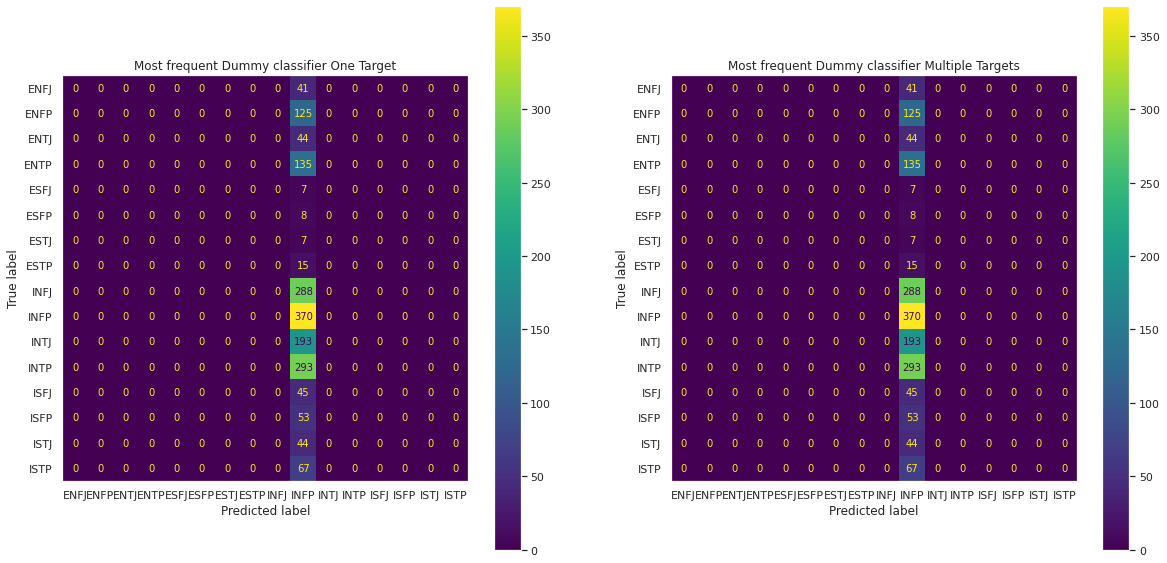

In [45]:
print_confusion_matrices(
    dummy_frequent, 
    dummy_multi_frequent, 
    X_test_tfidf, 
    "Most frequent Dummy classifier One Target", 
    "Most frequent Dummy classifier Multiple Targets"
)

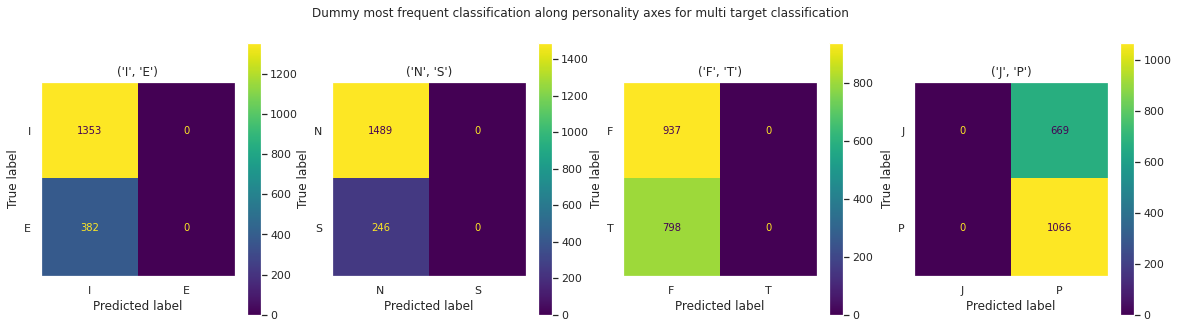

In [46]:
print_multi_confusion_matrix(
    dummy_multi_frequent, 
    X_test_tfidf,
    'Dummy most frequent classification along personality axes for multi target classification'
)

## Models

In [36]:
from sklearn.multioutput import MultiOutputClassifier
mbti_labels = ['ENFJ', 'ENFP', 'ENTJ', 'ENTP','ESFJ','ESFP','ESTJ','ESTP','INFJ','INFP','INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP']

### Multinomial Bayes 

For Multinomial bayes we choose **alpha=3** as it seems to perform the best. It is interesting that it is not true for MultiOutputClassifier, where we stick to **alpha=1** (default).

In [28]:
from sklearn.naive_bayes import MultinomialNB

multiNB = MultinomialNB(alpha=3)
multiNB.fit(X_train_count, y_train)
print('multiNB Accuracy:', multiNB.score(X_test_count, y_test))
print('multiNB F1:', f1_score(multiNB.predict(X_test_tfidf), y_test, average='weighted'))

multiNB Accuracy: 0.5613832853025936
multiNB F1: 0.5129700896080471


Multiple targets

In [37]:
multi_multiNB = MultiOutputClassifier(MultinomialNB())
multi_multiNB.fit(X_train_tfidf, y_train_multi)
print('multiNB:', multi_multiNB.score(X_test_count, y_test_multi))
get_multi_scores(multi_multiNB.predict(X_test_count), y_test_multi)

multiNB: 0.41037463976945243
----Accuracy Score----
   Total:0.41037   ('I', 'E'):0.82536   ('N', 'S'):0.86686   ('F', 'T'):0.73545   ('J', 'P'):0.73660  

----F1 Score----
   Total:0.44802   ('I', 'E'):0.84733   ('N', 'S'):0.91012   ('F', 'T'):0.74702   ('J', 'P'):0.74674  




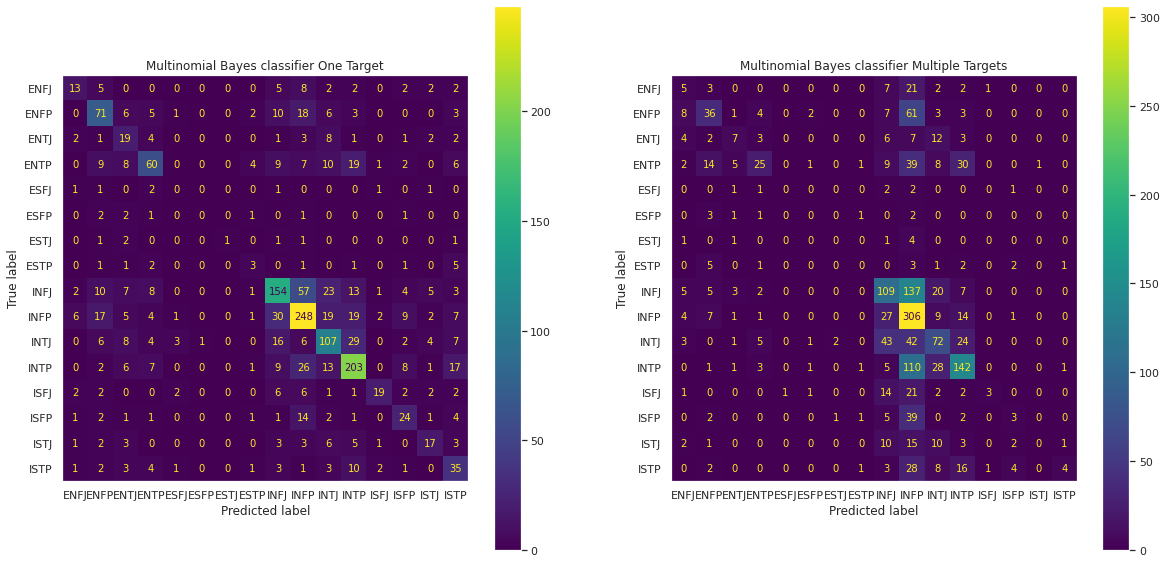

In [50]:
print_confusion_matrices(
    multiNB, 
    multi_multiNB, 
    X_test_count, 
    "Multinomial Bayes classifier One Target", 
    "Multinomial Bayes classifier Multiple Targets"
)

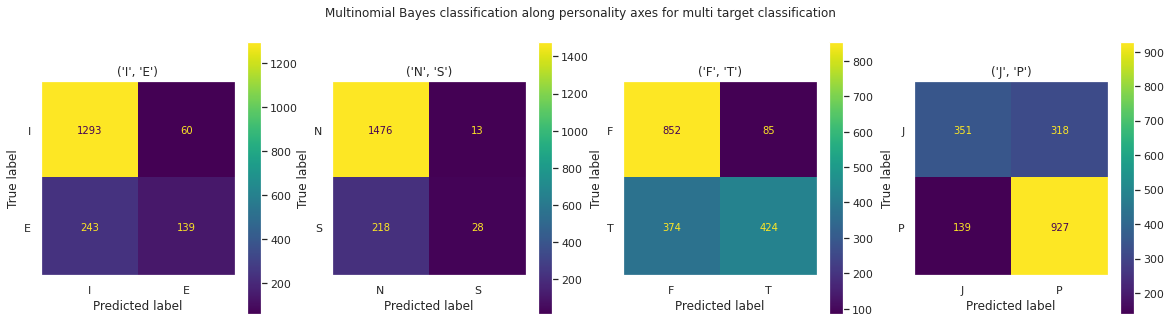

In [51]:
print_multi_confusion_matrix(
    multi_multiNB, 
    X_test_count,
    'Multinomial Bayes classification along personality axes for multi target classification'
)

### Complement Naive Bayes

For Complement naive bayes we used **alpha=4** in both cases.

In [29]:
from sklearn.naive_bayes import ComplementNB

compleNB = ComplementNB(alpha=4)
compleNB.fit(X_train_count, y_train)
print('complementNB Accuracy:', compleNB.score(X_test_count, y_test))
print('complementNB F1:', f1_score(compleNB.predict(X_test_tfidf), y_test, average='weighted'))

complementNB Accuracy: 0.5919308357348703
complementNB F1: 0.5853676467744574


Multiple targets

In [38]:
multi_compleNB = MultiOutputClassifier(ComplementNB(alpha=4))
multi_compleNB.fit(X_train_count, y_train_multi)
get_multi_scores(multi_compleNB.predict(X_test_count), y_test_multi)

----Accuracy Score----
   Total:0.44092   ('I', 'E'):0.80115   ('N', 'S'):0.84784   ('F', 'T'):0.82536   ('J', 'P'):0.72507  

----F1 Score----
   Total:0.41899   ('I', 'E'):0.79416   ('N', 'S'):0.83474   ('F', 'T'):0.82510   ('J', 'P'):0.72293  




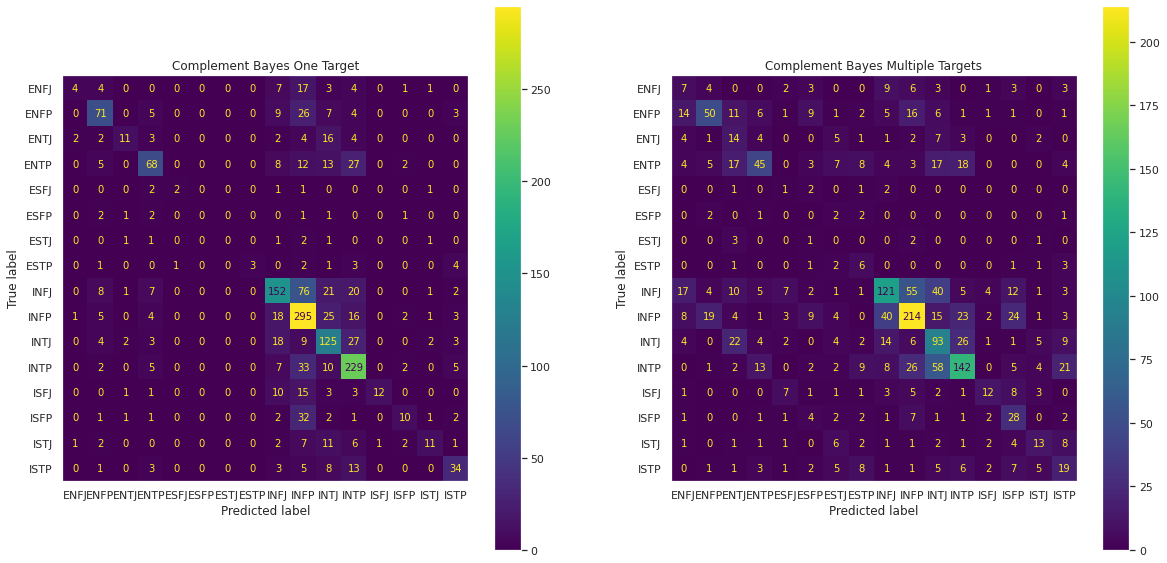

In [54]:
print_confusion_matrices(
    compleNB, 
    multi_compleNB, 
    X_test_count, 
    "Complement Bayes One Target", 
    "Complement Bayes Multiple Targets"
)

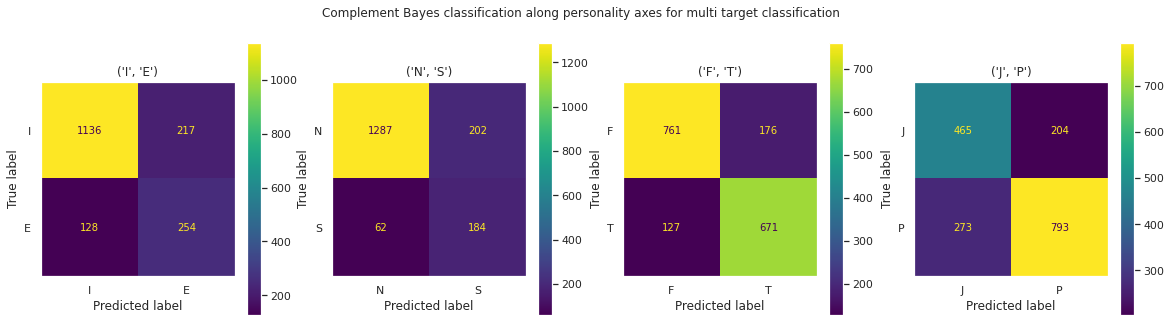

In [55]:
print_multi_confusion_matrix(
    multi_compleNB, 
    X_test_count,
    'Complement Bayes classification along personality axes for multi target classification'
)

We can see that there is common error to confuse only just one of category, the model tend to classify posts towards to more common categories (e.g. INFP instead of INFJ, INFP instead of ENFP, INTP instead of ISTP and so on).
We can see that model performs very well in classifying just one of features. It is struggling only with Relation to external world (J/P).

On the other hand, Multinomial Bayes classification performs quite poor on classifying one of category as it tends to classify as more common category. We would probably need more balanced data to increase performance of Multinomial Bayes.

Overall performance of Complement Naive Bayes classification is quite good in classifying posts to correct label as it has accuracy of ~59% in contrast to ~21% of Dummy classification. F1 score is also much higher.

### Logistic Regression 

#### 2.5 Training 

For the Logistic Regression TF-IDF representation of documents proved to work the best. This due to the fact that TF-IDF values are normalized, they put greater importance on words that helps us distinguish the classes and Logistic Regression performs well on continous values.

A GridSearch algorithm with 3 fold cross validation was used to find the best parameter configuration.

GridSearch

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

parameters = {
    "class_weight": ['balanced'], 
    "penalty": ['l2', 'none'], 
    "solver": ['newton-cg', 'lbfgs'], 
    "multi_class": ['ovr'],
}

logi_grid = GridSearchCV(LogisticRegression(), parameters, cv=3, n_jobs=-1)
logi_grid.fit(X_train_tfidf, y_train)
print(logi_grid.best_params_)

{'class_weight': 'balanced', 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}


#### 2.6 Interpretation 

Model parameters:
   * class_weight="balanced" was chosen to account for imbalanced personality that was shown in the preprocessing section
   * multi_class="ovr" fits the binary classification to each label and proved to work best
   * values for solver and penalty were taken as best result from the gridsearch. 

We can see from confusion matrix for One Target classification the two problematic areas for the model are personalities that start with 'IN' and 'EN'.

One target classification

In [30]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight="balanced", solver='lbfgs', multi_class='ovr', penalty='l2')
lr.fit(X_train_tfidf, y_train)
print('LR Accuracy', lr.score(X_test_tfidf, y_test))
print('LR F1', f1_score(lr.predict(X_test_tfidf), y_test, average='weighted'))

LR Accuracy 0.6708933717579251
LR F1 0.6732703811987105


Multiple targets

In [39]:
lr_multi = MultiOutputClassifier(LogisticRegression(class_weight="balanced", solver='lbfgs', multi_class='ovr', penalty='l2'))
lr_multi.fit(X_train_tfidf, y_train_multi)
get_multi_scores(lr_multi.predict(X_test_tfidf), y_test_multi)

----Accuracy Score----
   Total:0.53256   ('I', 'E'):0.84207   ('N', 'S'):0.87378   ('F', 'T'):0.84380   ('J', 'P'):0.78617  

----F1 Score----
   Total:0.52215   ('I', 'E'):0.83847   ('N', 'S'):0.86676   ('F', 'T'):0.84357   ('J', 'P'):0.78513  




#### 2.6 Evaluation 

LR proved to work best out of all models. Its accuracy is 0.67 and F1 score 0.67. That is more than 45% improvement compared to the baseline. As with other models multi target classification performed significantly worse than one target classification.

Confusion Matrices

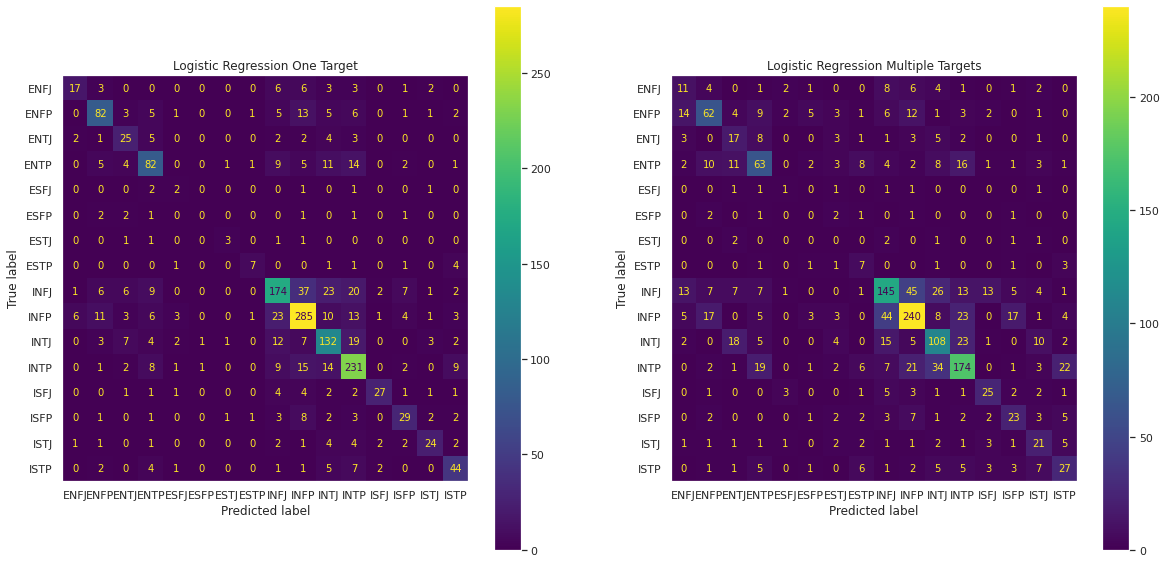

In [59]:
print_confusion_matrices(
    lr, 
    lr_multi, 
    X_test_tfidf, 
    "Logistic Regression One Target", 
    "Logistic Regression Multiple Targets"
)

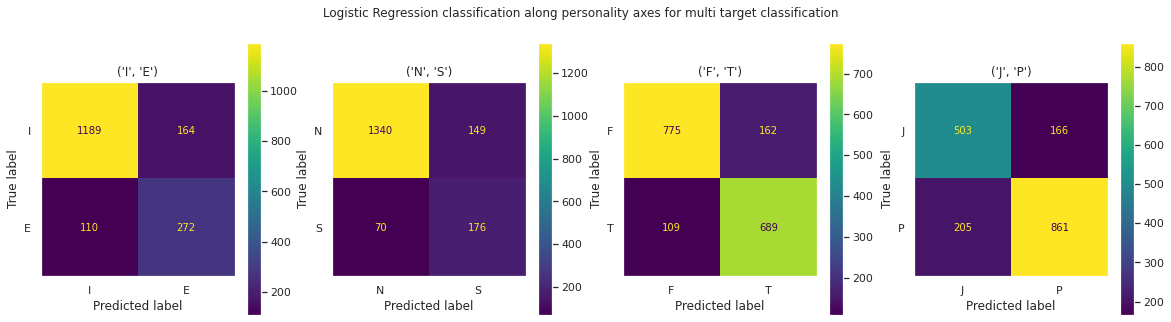

In [60]:
print_multi_confusion_matrix(
    lr_multi, 
    X_test_tfidf,
    'Logistic Regression classification along personality axes for multi target classification'
)

### KNearest Neighbors

We use the **weights='distance'** for determining the label, so that the closets neighbours contribute the most. The option **p=2** means that euclidean distance is being used. I also tried using cosine distance for the weight parameter, but **distance** proved to work better. I also tried using both LSA and TF-IDF representation of the posts and LSA yielded better results.

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from scipy import spatial

def cosine_d(x, y):
    return spatial.distance.cosine(x, y)

# With LSA
k_nearest_lsa = KNeighborsClassifier(n_neighbors=30, weights='distance', p=2)
k_nearest_lsa.fit(X_train_lsa, y_train)
print('KNearest Accuracy', k_nearest_lsa.score(X_test_lsa, y_test))
print('KNearest F1', f1_score(k_nearest_lsa.predict(X_test_lsa), y_test, average='weighted'))

KNearest Accuracy 0.5602305475504322
KNearest F1 0.578896517892034


In [62]:
# With TFIDF
k_nearest_tfidf = KNeighborsClassifier(n_neighbors=30, weights='distance', p=2)
k_nearest_tfidf.fit(X_train_tfidf, y_train)
k_nearest_tfidf.score(X_test_tfidf, y_test)

0.49279538904899134

Multiple targets

In [40]:
multi_k_nearest = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=30, weights='distance', p=2))
multi_k_nearest.fit(X_train_lsa, y_train_multi)
get_multi_scores(multi_k_nearest.predict(X_test_lsa), y_test_multi)

----Accuracy Score----
   Total:0.51873   ('I', 'E'):0.83689   ('N', 'S'):0.88588   ('F', 'T'):0.81844   ('J', 'P'):0.76888  

----F1 Score----
   Total:0.5464   ('I', 'E'):0.86660   ('N', 'S'):0.91836   ('F', 'T'):0.81815   ('J', 'P'):0.77980  




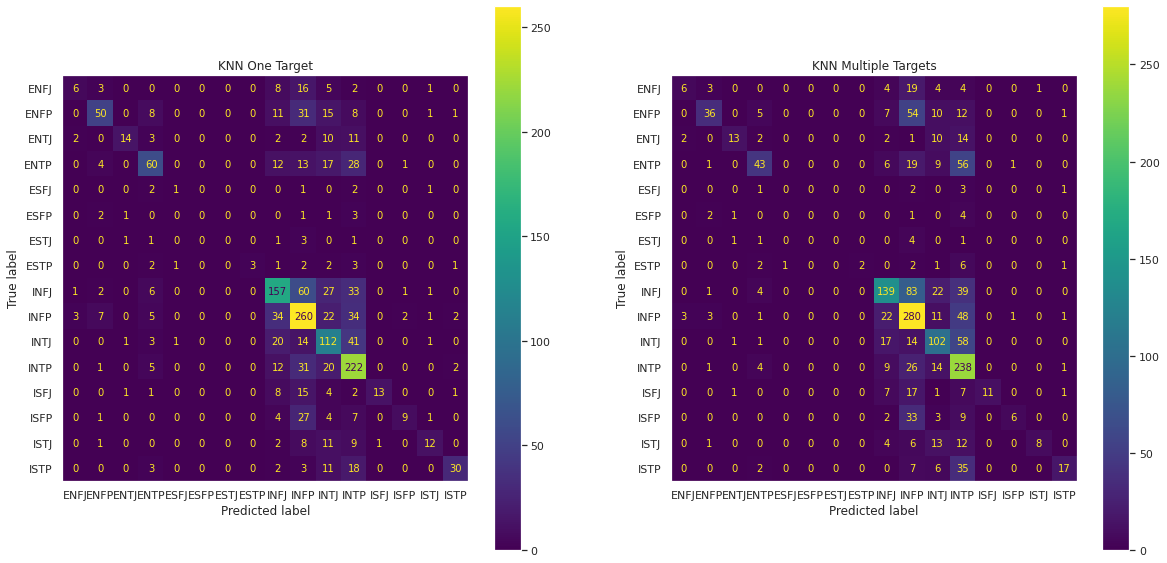

In [64]:
print_confusion_matrices(
    k_nearest_lsa, 
    multi_k_nearest, 
    X_test_lsa, 
    "KNN One Target", 
    "KNN Multiple Targets"
)

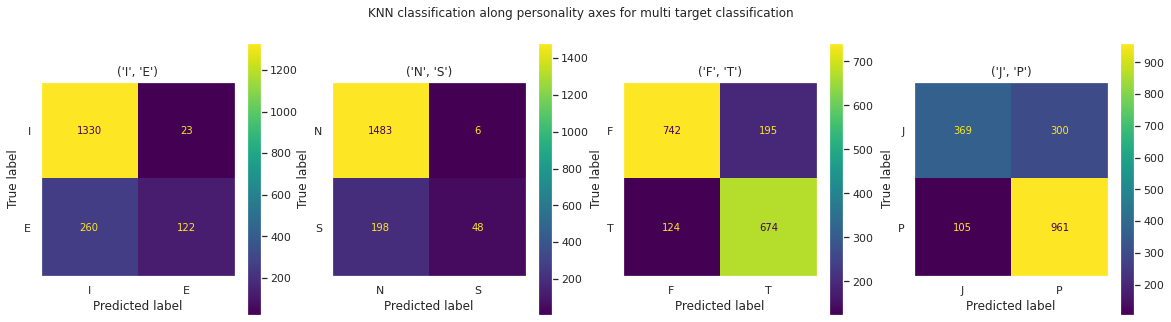

In [65]:
print_multi_confusion_matrix(
    multi_k_nearest, 
    X_test_lsa,
    'KNN classification along personality axes for multi target classification'
)

As we can see from the confusion matrices, most of the wrongly predicted labels were in the IN category, due to their overrepresentation. The accuracy and f1 score was 0.56, which is higher than the scores of the baseline (0.21). We can also see in the multiple targets confusion matrix, that there are more wrongly predicted labels also in the SN category in contrast to the one target matrix.

## 8 Results summary

Results were consistent across multiple divisions of data on train and test sets.
Sorted models (one target classification) with respect to F1 score:
1. Logistic regression with F1 score of 0.673. 
2. Complement Bayes with F1 score of 0.585.
3. KNN with F1 score of 0.579
4. Baseline with F1 score of 0.351

Logistic regression performed the best since it was able to learn features from TF-IDF text representation which encodes documents in the best way. Naive Bayes could not be trained on TF-IDF since it operates on discrete values. KNN performed similar to Naive Bayes, KNN had to be used with LSA representation to reduce dimensionality of TF-IDF and make searching more effective.

We were quite surprised that multi target classification was in almost all cases worse than one target. For Dummy classifier multi target classification yields same results.